In [1]:
%matplotlib inline

# Neural Networks and Learning Machines
## Exercise 5 - Convolutional ANN and Transfer learning

In [2]:
epochs = 30

# Introduction
The goal of this exercise is for you to get a better understanding of what convolution is, how it is leveraged to increase the usability and performance of neural networks. The exercise will also teach you about transfer learning and the differences between fine-tuning/feature extraction. 

## Literature
This exercise will rely on the following sections in the [course book](https://www.deeplearningbook.org/).

- Chapter 9
    - Most of it
- Chapter 7
    - Section 7.4 - Dataset augmentation
- Chapter 15
    - Section 15.2 - Transfer learning
    
## Examination
Epochs are predefined to be 30. Feel free to increase/decrease this number depending on the hardware that you are working with. Just make sure that you use the same hyperparameters on tasks 2, 3 and 4. **Make sure you have all examination requirements in order before presenting.**

### Task 1
1. Implementation of same convolution.
2. The resulting image using 3 different filters.

### Task 2
1. The given network trained, validated and tested on the given dataset. Don't forget to make the train/validation/test split of the dataset. This can be achieved programmatically using https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split.
2. Some type of regularization should be used. You should understand how the chosen regularization technique works.
3. Report the training, validation and test accuracy. (Should beat randomly picking)
4. Calculate and plot the multi-class [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).
5. Add some augmentation techniques which fits well with the data. Does this increase or decrease the validation accuracy?

### Task 3
1. Fine-tune Resnet18 on the given dataset.
2. Report the training, validation and test accuracy. (Should beat randomly picking)
3. Calculate and plot the multi-class [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).
4. Add some augmentation techniques which fits well with the data. Does this increase or decrease the validation accuracy?

### Task 4
1. Use Resnet18 as a feature extractor on the dataset.
2. Report the training, validation and test accuracy. (Should beat randomly picking)
3. Calculate and plot the multi-class [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).
4. Add some augmentation techniques which fits well with the data. Does this increase or decrease the validation accuracy?

In [3]:
import matplotlib.pyplot as plt
from sklearn import metrics
import torch

# Confusion matrix
import torch
import matplotlib.pyplot as plt
from sklearn import metrics

def confusion_matrix(model, test_loader, model_path='best_model.pth', class_labels=[0, 1]):
    
    # Load the trained model weights
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_labels = []
    all_predictions = []

    # Disable gradient calculation for evaluation
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Compute the confusion matrix
    cm = metrics.confusion_matrix(all_labels, all_predictions)

    # Set up the figure with a proper aspect ratio
    fig, ax = plt.subplots(figsize=(6, 6))  # Adjust figure size
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    cm_display.plot(cmap='Blues', values_format='d', ax=ax)

    # Adjust layout for a cleaner look
    plt.tight_layout()
    plt.show()


# Convolution in Neural Networks
A convolutional neural network, CNN for short, is a type of ANN that consists of at least one convolutional layer. CNN's are often used where the input size may vary such as when we are dealing with image input. The architecture of CNNs was inspired by how the visual cortex functions in our brain.

## Task 1: Implement convolution
Implement 2d same convolution without using a built-in convolution function. This should function as described in [this blog post](https://jcbgamboa.github.io/2017/08/12/what-are-convolutions/). One of the great strengths of convolution is that it functions on any sized image, hence it is important that your implementation also does. Same convolution means that the dimensions of the output are the same as the dimensions of the input. This is achieved by padding the input.

Once you have implemented a function that performs 2d convolution, use that to perform convolution over all channels in this image. Show the result using 3 different filters.

To find the padding needed to get the input to be the same space as the output you can use the formula:

$$ n_{out} = \left \lfloor\frac{n_{in}+2p-k}{s} \right \rfloor+1 $$

where $n_{out}$ is the number of output features, $n_{in}$ is the number of input features, $k$ is the kernel size, $p$ is the padding size and $s$ is the stride size. You can assume that the stride is always 1.

[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]


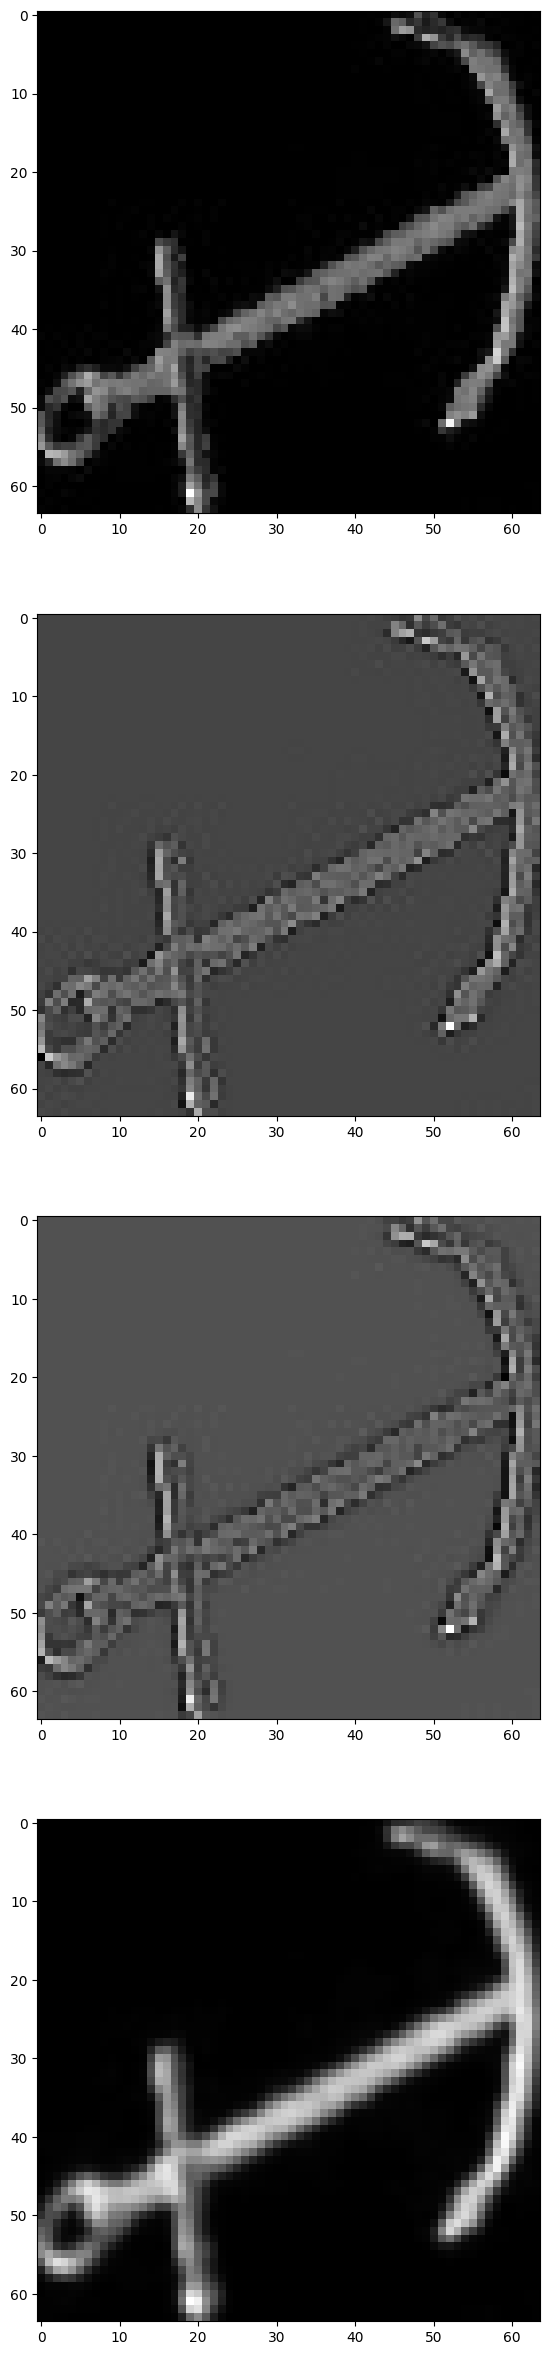

In [4]:
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 30]
plt.rcParams['figure.dpi'] = 100

# Implement same convolution in the function below (kernel is a 2d numpy array an example of which can be found in the test)

def conv(image, kernel, strides=1):
    # Get dimensions
    img_h, img_w = image.shape
    k_h, k_w = kernel.shape
    
    #Check padding size
    pad_h = k_h // 2
    pad_w = k_w // 2

    # Add padding
    image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=0)


    # Output dimensions
    out_h = (img_h - k_h+2*pad_h) // strides + 1
    out_w = (img_w - k_w+2*pad_w) // strides + 1

    
    # Initialize output
    output = np.zeros((out_h, out_w))
    
    # Perform convolution
    for i in range(0, out_h):
        for j in range(0, out_w):
            region = image[i * strides: i * strides + k_h, j * strides: j * strides + k_w]
            output[i, j] = np.sum(region * kernel)  # Element-wise multiplication & summation
    
    return output


# Our test, don't edit
inp = np.array([[1,1,1,1],[1,1,2,1],[1,-3,-4,1],[1,1,1,1]])
kernel = np.array([[0,1,0],[1,2,1],[0,1,0]]) # This is the second input of conv()

# If all are TRUE the convolution is implemented correctly
ans = np.array([[4, 5, 6, 4], [5, 3, 3, 6], [1, -7, -7, 0], [4, 1, 0, 4]])
print(conv(inp, kernel) == ans)

f, axarr = plt.subplots(4,1)

# How to load images using opencv
image_path = "ANN3_dataset/101_ObjectCategories_2classes/anchor/image_0001.jpg" # add your file path here
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # gray scale so we dont have to deal with more than 1 channel

#Padding


# Define your 3 kernels
kernel_1 = np.array([[ 0, -1,  0],[-1,  5, -1], [ 0, -1,  0]]) 
kernel_2 = np.array([[ -1, -1,  -1],[-1,  8, -1],[ -1, -1,  -1]])
kernel_3 = (1/16) * np.array([[1, 2, 1],[2, 4, 2],[1, 2, 1]])


# Perform the convolution (might take a couple of seconds depending on the implementation)
output1 = conv(image, kernel_1)
output2 = conv(image, kernel_2)
output3 = conv(image, kernel_3)

# plot the loaded image and the 3 convoluted images
axarr[0].imshow(image, cmap="gray")
axarr[1].imshow(output1, cmap="gray")
axarr[2].imshow(output2, cmap="gray")
axarr[3].imshow(output3, cmap="gray")

plt.show()

# Computer Vision
Computer vision (CV) is a task within the computer science field that aim is to extract high-level information from static images or video. Such high-level information can be, but is not limited to:
* Object detection - Detect and classify objects within input images
* Anomaly detection - Detect anomalies in the input images
* Semantic segmentation - Classify each pixel in the input image into different classes
* Object recognition - Classifying an entire image depending on what it contains

CV has been studied for multiple decades where early solutions used handwritten feature extractors to extract information from the input. However, with the increase of computing power together with the rise of deep learning algorithms, the main method used to solve CV problems is convolutional neural networks.

In this exercise, we will be taking a closer look at object recognition by first using a randomly initialized network and then utilizing transfer learning. **The dataset we will use for this exercise can be downloaded on canvas**. It is a subset of [this dataset](http://www.vision.caltech.edu/Image_Datasets/Caltech101/). Remember to split the data into separate training, validation and test set.

## Task 2: Implement the missing code and train it on the given dataset.
For task 2, implement the missing parts of the code below. The code should correctly train, validate and test the model. There are some comments guiding you through the process, however if something is unclear try to leverage the documentation for pytorch found [here](https://pytorch.org/docs/stable/index.html). You should also add some type of regularization into your model.

Remember to check the examination requirements in the start of this notebook.

Split sizes: train=58, validation=16, test=10
Epoch 1/30, Loss: 0.7109761536121368
Validation Loss: 0.7132343649864197, Accuracy: 47.05882352941177%
Epoch 2/30, Loss: 0.6809341609477997
Validation Loss: 0.7015812993049622, Accuracy: 47.05882352941177%
Epoch 3/30, Loss: 0.6616058051586151
Validation Loss: 0.7011790871620178, Accuracy: 47.05882352941177%
Epoch 4/30, Loss: 0.6388105154037476
Validation Loss: 0.7143915295600891, Accuracy: 47.05882352941177%
Epoch 5/30, Loss: 0.604116290807724
Validation Loss: 0.7145070433616638, Accuracy: 58.8235294117647%
Epoch 6/30, Loss: 0.5597864389419556
Validation Loss: 0.7222439646720886, Accuracy: 52.94117647058823%
Epoch 7/30, Loss: 0.4957257956266403
Validation Loss: 0.7796682715415955, Accuracy: 58.8235294117647%
Epoch 8/30, Loss: 0.44565968215465546
Validation Loss: 0.7689038515090942, Accuracy: 58.8235294117647%
Epoch 9/30, Loss: 0.4098534882068634
Validation Loss: 0.8194450736045837, Accuracy: 58.8235294117647%
Epoch 10/30, Loss: 0.3848866224

C:\Users\anton\AppData\Local\Temp\ipykernel_10864\4037428059.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))
C:\User

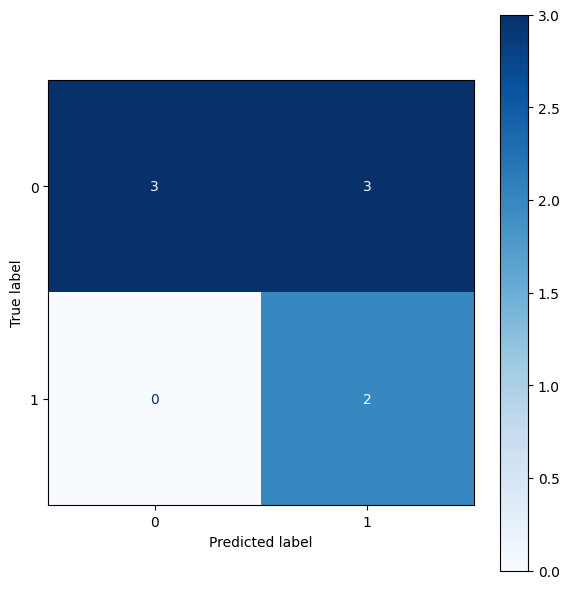

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision
import torchvision.models as models
import torch.optim as optim
import copy
import torchvision.transforms as v2
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import os


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 13 * 13, 120)
        self.fc2 = nn.Linear(120, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # 3x224x224 -> 6x110x110 -> 6x55x55
        x = self.pool(F.relu(self.conv2(x))) # 6x55x55 -> 16x26x26 -> 16x13x13
        x = x.view(-1, 16 * 13 * 13) # Flatten
        x = F.relu(self.fc1(x)) # 16x13x13 -> 120
        x = self.fc2(x) # 120 -> 2
        return x

# Implement a train model function so you can re_use it in task 3 and 4. 
# Should return the best performing model after training
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    # Define loss function and optimizer
    
    train_loss = []
    val_loss_array = []
    # Training loop
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            
            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")
        train_loss.append(running_loss/len(train_loader))
        

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            # Save the best model
            
            

            # Save the best model based on validation accuracy
            if epoch == 0 or (100 * correct / total) > best_accuracy:
                best_accuracy = 100 * correct / total
                best_model_wts = copy.deepcopy(model.state_dict())
                if os.path.exists('best_model.pth'):
                    os.remove('best_model.pth')
                torch.save(best_model_wts, 'best_model.pth')
                
                
        val_loss_array.append(val_loss/len(val_loader))

        print(f"Validation Loss: {val_loss/len(val_loader)}, Accuracy: {100 * correct / total}%")
    print(f"Best validation accuracy: {best_accuracy}%")


def test_model(model , test_loader):
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test accuracy: {100 * correct / total}%")
    return 100 * correct / total


# Hyperparams. Set these to reasonable values
BATCH_SIZE = 32
SHUFFLE = True
LEARNING_RATE = 0.001

# Train augmentations
transforms = transforms.Compose([
    # Add training augmentations here, remember: we do not want to transform the validation images.
    # For information about augmentation see: https://pytorch.org/vision/stable/transforms.html
    transforms.RandomHorizontalFlip(p=0.5),  # Flip images with 50% chance
    transforms.RandomRotation(20),  # Rotate up to 20 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust color properties
    transforms.RandomAffine(degrees=0, shear=10),  # Shear transformation
    transforms.ToTensor()
])

# Load the full dataset, perform the training/validation/test split and then load the subsets into dataloaders.
# Remember that the training images should be augmentated.
DATA_DIR = "ANN3_dataset/101_ObjectCategories_2classes/" # Path to dataset

# Load the dataset
dataset = datasets.ImageFolder(DATA_DIR, transform=None)

validation_split = 0.2
train_split = 0.7
test_split = 0.1

# Split the dataset into training, validation, and test sets
generator = torch.Generator().manual_seed(42)

# Define the sizes for each split
train_size = int(train_split * len(dataset))
val_size = int(validation_split * len(dataset))
test_size = len(dataset) - train_size - val_size

print(f'Split sizes: train={train_size}, validation={val_size}, test={test_size}')



# Split the dataset into training, validation, and test sets
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_split, validation_split, test_split], generator=generator)



# Create the dataloaders
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE)



# Load our network
model = Net()
# Apply the transformations to the training dataset
train_dataset.dataset.transform = transforms

# Apply the transformations to the validation and test datasets
val_dataset.dataset.transform = v2.transforms.Compose([v2.transforms.ToTensor()])
test_dataset.dataset.transform = v2.transforms.Compose([v2.transforms.ToTensor()])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
trained_model = train_model(model, criterion, optimizer, train_loader, val_loader, epochs)

# Test the model
tested_model = test_model(model,test_loader)

# Plot the confusion matrix
model.load_state_dict(torch.load('best_model.pth'))

confusion_matrix(model, test_loader)

# Transfer learning
Transfer learning refers to the practice to use a model which has already been pre-trained on a large dataset to be able to solve task $T_1$, replace the output layer or a few of the upper layers within this model and retrain the model on a smaller dataset to be able to solve task $T_2$. Formally this can be described as the following:

__Def 1:__ Let $D_s$ be the source domain and $T_s$ be the corresponding source task. Let $D_t$ be the target domain and $T_t$ be the corresponding target task. Let $f_t$ be the predictive function for $T_s$. Thus transfer learning aims to improve the learning of $f_t$ in $D_t$ using the already learned knowledge in $D_s$ and $T_s$ where $D_s \neq D_t$ and $T_s \neq T_t$.

The benefit from using transfer learning is that we can train an accurate computer vision model with relatively small amounts of data and computing resources compared to the costly pretraining process of the full convolutional neural network (a few days using multiple GPUs). 

## Fine-tuning and Feature extraction
There are two main ideas when it comes to transfer learning, fine-tuning and feature extraction. When using fine-tuning we allow all weights to be changed during the training phase. However, when we use the pre-trained model as a feature extractor we instead freeze earlier layers of the model, which means that the weights in those layers will not be updated during the training phase and we only update the weights in the upper layers that we have replaced. 

This works because low-level information extracted from the input image is universal between tasks, examples of such information is edge detection, shape detection and pattern detection. This is what the early layers are optimized to do, where later layers extract more abstract features relevant for the task. 

Most of the pre-trained models in PyTorch are trained on [ImageNet](http://www.image-net.org/). 

In this exercise, we use ResNet18 as our model. You should make yourself familiar with the Resnet18 architecture using, for example, [the paper](https://arxiv.org/abs/1512.03385).

## Task 3: Fine-tuning
In task 3 you should fine-tune Resnet18 to the small dataset which is provided above. Some code has been given to you. Remember to re-use functions (such as trained_model) from task 2 to decrease the implementation time.

Remember to check the examination requirements at the start of this notebook.

c:\Users\anton\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\anton\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30, Loss: 12.807215690612793
Validation Loss: 22.02178955078125, Accuracy: 0.0%
Epoch 2/30, Loss: 4.363065481185913
Validation Loss: 15.601020812988281, Accuracy: 11.764705882352942%
Epoch 3/30, Loss: 1.3762003779411316
Validation Loss: 8.002148628234863, Accuracy: 41.1764705882353%
Epoch 4/30, Loss: 0.260472409427166
Validation Loss: 6.070159435272217, Accuracy: 64.70588235294117%
Epoch 5/30, Loss: 0.009344163816422224
Validation Loss: 5.54850959777832, Accuracy: 76.47058823529412%
Epoch 6/30, Loss: 0.004318855877500027
Validation Loss: 5.4063720703125, Accuracy: 76.47058823529412%
Epoch 7/30, Loss: 0.003575105336494744
Validation Loss: 5.288792610168457, Accuracy: 76.47058823529412%
Epoch 8/30, Loss: 0.002415199880488217
Validation Loss: 5.081981658935547, Accuracy: 76.47058823529412%
Epoch 9/30, Loss: 0.11209948715986684
Validation Loss: 5.128804683685303, Accuracy: 82.3529411764706%
Epoch 10/30, Loss: 0.09685751399956644
Validation Loss: 5.239778518676758, Accuracy: 82.3529

C:\Users\anton\AppData\Local\Temp\ipykernel_10864\4037428059.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))
C:\User

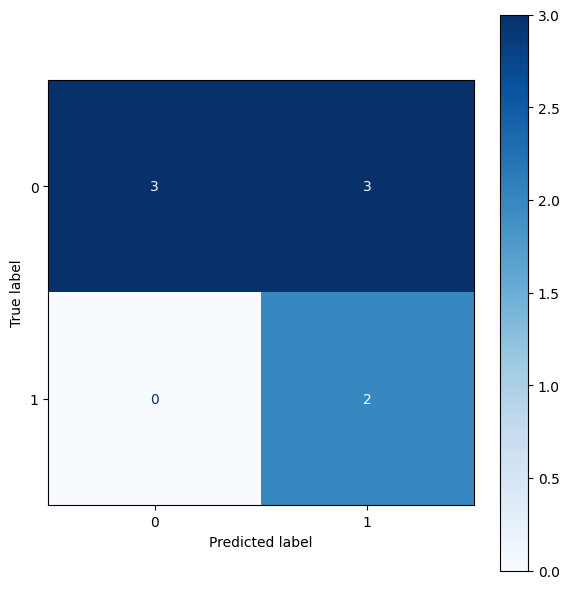

In [6]:
import matplotlib.pyplot as plt
from sklearn import metrics

# Fine-tune a model to the dataset
# We use resnet18 as the model.
model_ft = models.resnet18(pretrained=True)

# Do the things required for fine-tuning before training the model
criterion_ft = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Train the model
trained_model_ft = train_model(model_ft, criterion_ft, optimizer_ft, train_loader, val_loader, epochs)

# Test the model
tested_model_ft = test_model(model_ft,test_loader)

#confusion matrix
confusion_matrix(model_ft, test_loader)



        



## Task 4: Feature extraction
In task 4, you should use Resnet18 as a feature extractor. Similarly to task 3, some code has been provided. Remember to re-use as much code as you can. 

Once again, check the examination requirements so you don't forget to implement some required functionality.

c:\Users\anton\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\anton\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30, Loss: 0.8128865659236908
Validation Loss: 0.6832758784294128, Accuracy: 52.94117647058823%
Epoch 2/30, Loss: 0.7766534686088562
Validation Loss: 0.673142671585083, Accuracy: 64.70588235294117%
Epoch 3/30, Loss: 0.6381592750549316
Validation Loss: 0.6560136079788208, Accuracy: 58.8235294117647%
Epoch 4/30, Loss: 0.5172472447156906
Validation Loss: 0.6679432988166809, Accuracy: 58.8235294117647%
Epoch 5/30, Loss: 0.5013613700866699
Validation Loss: 0.6940153241157532, Accuracy: 58.8235294117647%
Epoch 6/30, Loss: 0.420151486992836
Validation Loss: 0.7277817130088806, Accuracy: 58.8235294117647%
Epoch 7/30, Loss: 0.40819425880908966
Validation Loss: 0.7330328822135925, Accuracy: 58.8235294117647%
Epoch 8/30, Loss: 0.37903571128845215
Validation Loss: 0.7194212079048157, Accuracy: 58.8235294117647%
Epoch 9/30, Loss: 0.35042306780815125
Validation Loss: 0.6957744359970093, Accuracy: 52.94117647058823%
Epoch 10/30, Loss: 0.28757672011852264
Validation Loss: 0.6750448942184448, Ac

C:\Users\anton\AppData\Local\Temp\ipykernel_10864\4037428059.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))
C:\User

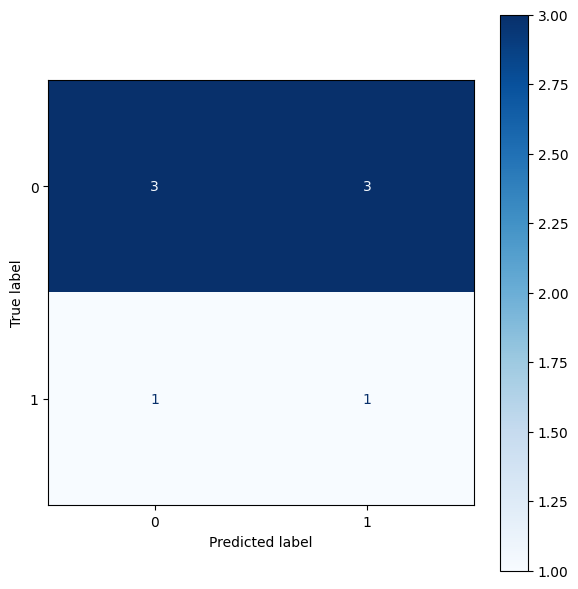

In [7]:
# Use a predefined model as a feature extractor

# We use resnet18 as the model.
model_fe = models.resnet18(pretrained=True)

# Do the things required for fine-tuning before training the model

# Freeze all layers except the final fully connected layer
for param in model_fe.parameters():
    param.requires_grad = False

# Modify the final layer to match the number of classes (e.g., num_classes = 10)
num_ftrs = model_fe.fc.in_features
model_fe.fc = nn.Linear(num_ftrs, 2)  # Adjust num_classes accordingly

# Define criterion, optimizer, and loaders
criterion_fe = nn.CrossEntropyLoss()
optimizer_fe = torch.optim.Adam(model_fe.fc.parameters(), lr=0.001)

# Train the model
trained_model_fe = train_model(model_fe, criterion_fe, optimizer_fe, train_loader, val_loader, epochs)

# Test the model
tested_model = test_model(model_fe,test_loader)

#confusion matrix
confusion_matrix(model_fe, test_loader)